<a href="https://colab.research.google.com/github/Krankile/npmf/blob/main/notebooks/lstm_vs_arima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Run when kernel initializes

In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
%%capture
!git clone https://github.com/Krankile/npmf.git

Run whenever updates are pushed to Github

In [24]:
%%capture
!cd npmf && git pull

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
from statsmodels.tsa.arima_model import ARIMA
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from pathlib import Path

import torch
from torch import nn

from torch import Tensor as T
from torch.nn import functional as F

from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
device

device(type='cuda')

In [27]:
data_dir = Path("/content/drive/MyDrive/12 – Master, Ankile og Krange/Master/Data/arima_nn")

In [28]:
class LSTM(nn.Module):

    def __init__(self, ins=1, hs=128, nl=2, do=0.5) -> None:
        super().__init__()

        self.rnn = nn.LSTM(
            input_size=ins,
            hidden_size=hs,
            num_layers=nl,
            batch_first=True,
            dropout=do,
        )

        self.p = nn.Linear(hs, 6)
        self.d = nn.Linear(hs, 3)
        self.q = nn.Linear(hs, 6)

    def forward(self, x):

        x, (h, c) = self.rnn(x)

        p = F.softmax(self.p(h[-1, :, :]), dim=1)
        d = F.softmax(self.d(h[-1, :, :]), dim=1)
        q = F.softmax(self.q(h[-1, :, :]), dim=1)

        return p, d, q

In [29]:
class ForecastDataset(torch.utils.data.Dataset):
    def __init__(self, series, orders, lens) -> None:
        self.series = series.values.astype(np.float32)
        self.orders = orders.values.astype(np.int16)
        self.lens = lens

    def __len__(self):
        return self.series.shape[0]

    def __getitem__(self, idx):
        return self.series[idx, :], self.orders[idx, :], self.lens[idx]

In [30]:
# Create series
series_path = data_dir / "monthly_train.feather"
series = pd.read_feather(series_path).set_index("V1").iloc[:12_000, ]
series.shape

(12000, 2794)

In [31]:
def normal(row):
    mi, ma = row.min(), row.max()

    return (row - mi) / ma

series = series.apply(normal, axis=1)

In [32]:
# Create orders
orders_path = data_dir / "pdq_12k.feather"
orders = pd.read_feather(orders_path).astype(np.int16)
orders[orders.d == 0]

,p,d,q
18,3,0,1
19,1,0,0
20,4,0,2
21,4,0,0
22,1,0,1
...,...,...,...
11782,1,0,2
11835,1,0,0
11882,5,0,0
11913,1,0,3


In [33]:
ser = orders.q

list((ser.value_counts() / ser.shape[0]).sort_index().to_list())

[0.21425,
 0.35233333333333333,
 0.24683333333333332,
 0.113,
 0.04425,
 0.029333333333333333]

array([469, 469, 469, ..., 306, 306, 306])

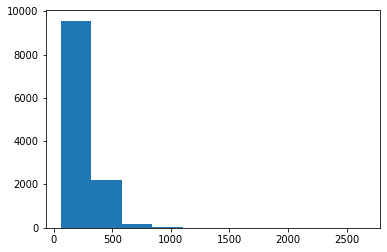

In [34]:
# Create lens
lens = np.array(list(map(lambda x: len(x[1].dropna()), series.iterrows())))
plt.hist(lens)
lens

In [35]:
tra_loader = torch.utils.data.DataLoader(
    ForecastDataset(series, orders, lens),
    batch_size=256,
)

In [36]:
def train_comb(net, train_data, loss_fn, epochs=1_000, device=torch.device("cpu")):

    net.train()
    net = net.to(device)
    optimizer = torch.optim.Adam(net.parameters())
    print(f"Started training on device {device}")

    it = tqdm(range(epochs), postfix=dict(tra_loss=0))

    # Epoch iterator
    for _ in it:
        losses = []

        for xs, actual, lens in tra_loader:
            
            xs = xs.unsqueeze(-1).type(torch.float32).to(device)

            #print(actual[:, 1])
            actual = actual.type(torch.long).to(device)
            packed = torch.nn.utils.rnn.pack_padded_sequence(xs, lens, True, False)
            
            p, d, q = net(packed)
            #print(d.cpu())
            loss = loss_fn(p, d, q, actual)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses.append(loss.item())

        it.set_postfix(dict(tra_loss=np.mean(losses)))

    return net.eval()

In [37]:
pw = T([0.0491, 0.0798, 0.0676, 0.1722, 0.2724, 0.3588]).to(device)
dw = T([0.7173, 0.0210, 0.2617]).to(device)
qw = T([0.0605, 0.0368, 0.0525, 0.1148, 0.2931, 0.4422]).to(device)


pc = nn.CrossEntropyLoss(weight=pw, reduction="sum")
dc = nn.CrossEntropyLoss(weight=None, reduction="sum")
qc = nn.CrossEntropyLoss(weight=qw, reduction="sum")


def pdq_loss(p, d, q, actuals):

    # p = pc(p, actuals[:, 0], weight=pw, reduction="sum")
    de = dc(d, actuals[:, 1])
    # q = qc(q, actuals[:, 2], weight=qw, reduction="sum")

    return de

In [38]:
lstm = LSTM(ins=1, hs=128, nl=2, do=0)

train_comb(lstm, tra_loader, loss_fn=pdq_loss, epochs=50, device=device)

Started training on device cuda


  0%|          | 0/50 [00:00<?, ?it/s, tra_loss=0]


RuntimeError: ignored

In [19]:
lstm = lstm.cpu()

ser = T(series.iloc[0, ].dropna().to_numpy()).reshape(1, -1, 1)
lstm(ser)

(tensor([[0.2802, 0.2024, 0.0648, 0.1092, 0.1954, 0.1479]],
        grad_fn=<SoftmaxBackward0>),
 tensor([[9.9999e-01, 8.0247e-07, 4.1873e-06, 7.4423e-07, 1.0804e-06, 6.9405e-07]],
        grad_fn=<SoftmaxBackward0>),
 tensor([[0.0993, 0.1773, 0.2279, 0.1433, 0.1296, 0.2225]],
        grad_fn=<SoftmaxBackward0>))

In [19]:
target = torch.LongTensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 0, 0, 0, 0, 0, 2,
        2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
        1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
        1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])

preds = T([[0.2395, 0.3389, 0.4216],
        [0.2394, 0.3391, 0.4214],
        [0.2418, 0.3323, 0.4260],
        [0.2382, 0.3422, 0.4195],
        [0.2385, 0.3415, 0.4200],
        [0.2402, 0.3366, 0.4232],
        [0.2392, 0.3393, 0.4214],
        [0.2400, 0.3370, 0.4229],
        [0.2385, 0.3415, 0.4200],
        [0.2382, 0.3422, 0.4196],
        [0.2413, 0.3335, 0.4252],
        [0.2407, 0.3351, 0.4242],
        [0.2408, 0.3349, 0.4243],
        [0.2414, 0.3331, 0.4255],
        [0.2412, 0.3339, 0.4250],
        [0.2415, 0.3329, 0.4256],
        [0.2416, 0.3326, 0.4258],
        [0.2414, 0.3334, 0.4253],
        [0.2394, 0.3392, 0.4214],
        [0.2387, 0.3410, 0.4203],
        [0.2396, 0.3386, 0.4218],
        [0.2390, 0.3403, 0.4207],
        [0.2394, 0.3391, 0.4215],
        [0.2425, 0.3305, 0.4271],
        [0.2424, 0.3307, 0.4269],
        [0.2424, 0.3307, 0.4269],
        [0.2419, 0.3318, 0.4263],
        [0.2416, 0.3327, 0.4257],
        [0.2413, 0.3335, 0.4252],
        [0.2416, 0.3326, 0.4257],
        [0.2409, 0.3346, 0.4245],
        [0.2417, 0.3324, 0.4259],
        [0.2420, 0.3318, 0.4263],
        [0.2417, 0.3326, 0.4257],
        [0.2410, 0.3342, 0.4247],
        [0.2415, 0.3330, 0.4255],
        [0.2404, 0.3360, 0.4236],
        [0.2420, 0.3317, 0.4263],
        [0.2420, 0.3318, 0.4263],
        [0.2415, 0.3329, 0.4255],
        [0.2389, 0.3406, 0.4205],
        [0.2387, 0.3411, 0.4203],
        [0.2390, 0.3402, 0.4209],
        [0.2395, 0.3386, 0.4220],
        [0.2397, 0.3380, 0.4223],
        [0.2387, 0.3409, 0.4204],
        [0.2400, 0.3372, 0.4227],
        [0.2401, 0.3370, 0.4229],
        [0.2395, 0.3386, 0.4219],
        [0.2397, 0.3381, 0.4222],
        [0.2394, 0.3391, 0.4215],
        [0.2417, 0.3324, 0.4259],
        [0.2388, 0.3407, 0.4205],
        [0.2390, 0.3399, 0.4211],
        [0.2422, 0.3313, 0.4266],
        [0.2394, 0.3387, 0.4218],
        [0.2392, 0.3395, 0.4213],
        [0.2396, 0.3382, 0.4222],
        [0.2401, 0.3371, 0.4228],
        [0.2395, 0.3388, 0.4217],
        [0.2392, 0.3391, 0.4217],
        [0.2399, 0.3375, 0.4226],
        [0.2396, 0.3381, 0.4222],
        [0.2393, 0.3392, 0.4215],
        [0.2392, 0.3394, 0.4214],
        [0.2394, 0.3388, 0.4218],
        [0.2394, 0.3387, 0.4219],
        [0.2398, 0.3377, 0.4225],
        [0.2399, 0.3374, 0.4227],
        [0.2397, 0.3380, 0.4223],
        [0.2401, 0.3369, 0.4230],
        [0.2394, 0.3390, 0.4216],
        [0.2397, 0.3379, 0.4224],
        [0.2394, 0.3389, 0.4217],
        [0.2391, 0.3397, 0.4212],
        [0.2410, 0.3343, 0.4246],
        [0.2401, 0.3367, 0.4231],
        [0.2394, 0.3386, 0.4219],
        [0.2401, 0.3370, 0.4229],
        [0.2403, 0.3365, 0.4232],
        [0.2393, 0.3394, 0.4214],
        [0.2395, 0.3386, 0.4219],
        [0.2401, 0.3368, 0.4231],
        [0.2392, 0.3395, 0.4214],
        [0.2397, 0.3378, 0.4224],
        [0.2393, 0.3393, 0.4214],
        [0.2396, 0.3385, 0.4219],
        [0.2398, 0.3379, 0.4223],
        [0.2386, 0.3412, 0.4202],
        [0.2402, 0.3366, 0.4232],
        [0.2400, 0.3371, 0.4229],
        [0.2423, 0.3310, 0.4267],
        [0.2411, 0.3342, 0.4247],
        [0.2414, 0.3333, 0.4253],
        [0.2395, 0.3386, 0.4219],
        [0.2398, 0.3379, 0.4224],
        [0.2403, 0.3365, 0.4232],
        [0.2410, 0.3344, 0.4246],
        [0.2414, 0.3333, 0.4253],
        [0.2406, 0.3354, 0.4240],
        [0.2415, 0.3330, 0.4255],
        [0.2415, 0.3331, 0.4254],
        [0.2402, 0.3366, 0.4232],
        [0.2403, 0.3363, 0.4234],
        [0.2411, 0.3340, 0.4249],
        [0.2391, 0.3397, 0.4212],
        [0.2407, 0.3353, 0.4240],
        [0.2407, 0.3353, 0.4240],
        [0.2385, 0.3415, 0.4200],
        [0.2406, 0.3355, 0.4239],
        [0.2397, 0.3381, 0.4222],
        [0.2399, 0.3374, 0.4227],
        [0.2407, 0.3351, 0.4241],
        [0.2414, 0.3332, 0.4254],
        [0.2407, 0.3352, 0.4241],
        [0.2406, 0.3355, 0.4239],
        [0.2421, 0.3313, 0.4266],
        [0.2417, 0.3325, 0.4258],
        [0.2413, 0.3337, 0.4251],
        [0.2413, 0.3334, 0.4253],
        [0.2413, 0.3336, 0.4251],
        [0.2418, 0.3322, 0.4260],
        [0.2397, 0.3383, 0.4220],
        [0.2404, 0.3359, 0.4237],
        [0.2402, 0.3367, 0.4231],
        [0.2402, 0.3367, 0.4231],
        [0.2408, 0.3350, 0.4242],
        [0.2413, 0.3341, 0.4246]])


F.nll_loss(preds, target, reduction="sum")

tensor(-43.0770)

# Archive

In [7]:
xs = np.linspace(0, 10, 200)
ys = np.sin(6*xs) + np.random.normal(0, 0.2, size=xs.shape)

ys += -min(0, ys.min())
ys /= ys.max()

t = -40

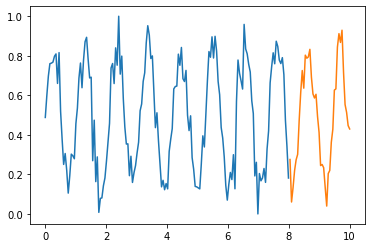

In [8]:
plt.plot(xs[:t], ys[:t])
plt.plot(xs[t:], ys[t:]);

In [9]:
mod = ARIMA(ys[:t], order=(10, 1, 0))
res = mod.fit()

res.summary()

KeyboardInterrupt: ignored

In [ ]:
y_hat = res.forecast(abs(t))[0]

print(f"MSE loss ARIMA {((ys[t:]-y_hat)**2).mean()}")

plt.plot(xs[:t], ys[:t])
plt.plot(xs[t:], y_hat);

In [ ]:
class NN(nn.Module):

    def __init__(self, lags, h, hidden) -> None:
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(lags, hidden),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(hidden, h),
        )
    
    def forward(self, x):
        return self.net(x)

In [ ]:
net = NN(200+t, abs(t), 128)
net

In [ ]:
y_hat2 = net(torch.Tensor(ys[:t])).detach().numpy()

print(f"MSE loss NN {((ys[t:]-y_hat2)**2).mean()}")

plt.plot(xs[:t], ys[:t])
plt.plot(xs[t:], y_hat2);

In [ ]:
def train(net, epochs=1_000, wd=0, noise=0.2, device=torch.device("cpu")):
    net = net.to(device)

    print(f"Started training on device {device}")

    optimizer = torch.optim.Adam(net.parameters(), weight_decay=wd)
    loss_fn = torch.nn.MSELoss()

    ys2 = np.sin(6*xs)

    ys2 += -min(0, ys2.min())
    ys2 /= ys2.max()

    net = net.train()

    for _ in tqdm(range(epochs)):

        y = ys2 + np.random.normal(0, noise, size=ys2.shape)

        x = torch.Tensor(y[:t]).to(device)
        actual = torch.Tensor(y[t:]).to(device)
        pred = net(x)
        loss = loss_fn(pred.squeeze(), actual)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    return net.eval()

In [ ]:
net = train(net, epochs=5_000)

In [ ]:
y_hat2 = net.cpu()(torch.Tensor(ys[:t])).detach().numpy()

print(f"MSE loss NN {((ys[t:]-y_hat2)**2).mean()}")

plt.plot(xs[:t], ys[:t])
plt.plot(xs[t:], y_hat2);

In [ ]:
class TCN(nn.Module):

    def __init__(self) -> None:
        super().__init__()

        self.c1 = nn.Conv1d(1, 64, 3, 1, 2*1, dilation=1)
        self.c2 = nn.Conv1d(64, 64, 3, 1, 2*2, dilation=2)
        self.c3 = nn.Conv1d(64, 64, 3, 1, 2*4, dilation=4)
        self.c4 = nn.Conv1d(64, 64, 3, 1, 2*8, dilation=8)

        self.out = nn.Linear(12160, 40)
    
    def forward(self, x):
        x = x.reshape((1, 1, -1))
        x = F.dropout(F.relu(self.c1(x)), p=0.5)
        x = F.dropout(F.relu(self.c2(x)), p=0.5)
        x = F.dropout(F.relu(self.c3(x)), p=0.5)
        x = F.dropout(F.relu(self.c4(x)), p=0.5)

        x = x.reshape(1, -1)
        x = self.out(x)

        return x

In [ ]:
tcn = TCN()
tcn

In [ ]:
tcn = train(tcn, epochs=5_000, wd=0.1, noise=0.3, device=device)

In [ ]:
y_hat2 = tcn.cpu()(torch.Tensor(ys[:t])).squeeze().detach().numpy()

print(f"MSE loss TCN {((ys[t:]-y_hat2)**2).mean()}")

plt.plot(xs[:t], ys[:t], label="Actual")
plt.plot(xs[t:], y_hat2, label="Predicted")
plt.plot(xs[t:], ys[t:], color="C0", linestyle="-.")
plt.legend();